# Basin Scale Scenario Analysis 

GroMore is proposing to start a new agricultural effort in the basin. Their proposal is included in the base model as the rectangular irrigated area with the elevated ET and the shallow pumping well. They are resistant to changing this plan (location of the farm, crop, location of pumping well, etc) because they have agreements with the current landowner and have done a market analysis based on the proposed pumping and the projected value of the crop. 


## Model Description 
Basin box model for scenario analysis 

#### Dimensions: 
- 50 x 50 x 3
- dx = dy = 1000 m
- dz =   

#### Topography
- Land surface elevation (base_model_elevs.csv file)
- Middle & bottom layers are horizontal.

#### Subsurface Properties: 
- Top & Bot layers 
          Kx = Ky = Kz = 10 m/day 
 
- Middle layer
          Kx = Ky = 10 m/d, 
          Kz = 10 m/d     1st 20 left most columns
          Kz = 1e-04      in the rest of the layer
 
- see NO FLOW corners in (NoFlow_Boundaries excel file)
- Porosity = 0.10
- Specific yield = 0.10
- Storage coefficient = 0.0001  

#### Boundary Conditions: 
   - Right boundary is a constant head of 70 m 
   - All other boundaries are no flow
   - Note NO FLOW boundaries in the domain (see map on excel file: NoFlow_Boundaries)
   - Recharge (uniform) occurs in the 1st 15 left most columns throughout the domain. R = 4E-5 m/d 
   - ET occurs in the right half of the model domain. ET = 1e-5 m/d
   - ET_rip occurse across the riparian area in the domain (row 23 thru row 29). ET_rip = 5e-5 m/d
 
#### Wells: 
 - Water Supply well (bottom layer)
       located at (38000,21000 ) or (row 21 & col 38)
       pumping rate = 1500 m^3/d
 

 
 - Monitoring wells (top layer)
      - MW1 located at (25000, 25000)
      - MW2 located at (12500, 12500)
       
#### Irrigation Field     
   . Located at (14000, 12000) or (row 12 & col 14)
     
   . Pumping at a rate of (crop water demand)+ 0.20(excess irrig) + 0.30 (irrig inefficiency) m^3/d 
       - for wheat,Q = 3000 m^3/d
       - for Pistachio,Q = 4500 m^3/d
       - for Cotton,Q = 6000 m^3/d
      
      * 1/8th of the area will be irrigated at any time (the field area is multiplied by 0.125).
      - located at (18000,20000) and (20000,22000) or (row 21 & 22 and col 19 & 20)
      - 2000 m x 2000 m area.
   - Recharge  (or the crop water use)       
       *  Wheat = 0.004m/d / 0.0001m/d
       *  Pistachios= 0.006m/d / 0.00015m/d
       *  Cotton: 0.008 m/d / 0.0002 m/d

### stream
      - runs from left to right domain boundary on row 26  
      - stream width, & thickness = 1 m
      - K of river sediment = 1000 m/d
      - stream bottom Elev = Zbot (of river grid cell) - 1 
      - stream stage = 0.5 m
    

### Scenario 1: Pre Development model, no seasonality¶

Build the base model as described above without the proposed agricultural activity.
- Run the model as steady state with no pumping from the town's well.
- Calculate the flux from the stream to the groundwater
- Also show a reverse particle track map to identify the source of the water to the stream.
- Finally, report the water level at the monitoring wells and at the town's well (even though it 
  isn't pumping for this scenario).

## 1. Setup the environment

In [1]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 

 #Delete Packages
#dir ="C:/Users/HG/Documents/AHWR_582/AFinalPro/GroMore_Project/Tesfa"
#files = os.listdir(dir)
#ext=['.dis','.bas','.lpf','.oc','.pcg','.wel','.hds','.cbc','.riv','.list','.nam','.evt',
#     '.rch','.mpbas','.mpend','.mplst','.mpnam','.mppth','.mpsim','.log','.timeseries',
#     '.lis','.chd','.ddn','.sloc']
#for file in files:
#    for i in range(0,len(ext)):
#        if file.endswith(ext[i]):
#            os.remove(os.path.join(dir,file))

flopy is installed in C:\Users\HG\Anaconda3\lib\site-packages\flopy


In [2]:
#print(len(ext))

## 2. Domain Inputs & BC

In [3]:
## Discritization
nrow = 50 
ncol = 50 
nlay = 3  
laytyp = 1

dx= 1000      
dy= 1000     

Lx = ncol*dx  #length of domain in x
Ly = nrow*dy #length of domain in y

ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)
ztop[0,0] = 124.                                           # insert missing initial value (not sure why didn't import)
#print(type(ztop))
#print(ztop.shape)
#print(ztop[0,:])


zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay    #cell height in z direction

## Timing
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

h_right = 70

## Subsurface properties
K_horiz = 10.    #horizontal hydraulic conductivity 
Kz_1 = 10      # vert hyd cond for left most 20 columns in layer 2. And, entire top & bot layers
Kz_2 = 1e-4  #vert hyd cond for the rest of columns in layer 2

n = 0.1        #porosity
Ss = 1e-4      #storage coefficient
Sy = 0.1        # specific yield
uncnf = 1       #0=confined, >0 = unconfined


Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz                 # assign the original value to the entire array

Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = Kz_1                   # assign Kz to all layers
Kz[1,:,20:48] = Kz_2                 #Replace the Kz in the middle layer with the lower Kz value

#Layer elevations
bot_elev = 0.  # bottom elevation of lowest layer 
mid_elev = 40. #bottom elevation of middle layer  
top_elev = 45. # bottom elevation of top layer  

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 
botm[1,:,:] = mid_elev                          
botm[0,:,:] = top_elev                 


#setting up Recharge
recharge_zone = np.zeros((1,nrow,ncol)) # define an array of zeros the size of the model grid

rech1 = 4e-5 # m/day
rech_llxy = [0,0]  # lower left xy coords
rech_urxy = [15000,50000] # upper right xy coords

##convert to rows and columns
rech_rowll = int(np.floor((nrow-1)-(rech_llxy[1]/dy))) #convert the y location to a row
rech_colll=int(np.floor(rech_llxy[0]/dx))          #convert the x location to a column
rech_rowur = int(np.floor((nrow)-(rech_urxy[1]/dy))) #convert the y location to a row
rech_colur=int(np.floor(rech_urxy[0]/dx))          #convert the x location to a column
#print(rech_colll, rech_rowll, rech_colur, rech_rowur)

recharge_zone[0,rech_rowur:rech_rowll, rech_colll:rech_colur] = rech1

# Setting up ET
ET_zone = np.zeros((1,nrow,ncol))#ET in left half of domain is zero
ET_right = 1e-5 #m/day ET over right of domain
ET_rip =5e-5 #ET in riparian area
extinction_depth = 10 #10m everywhere

ET_right_llxy = [25000,0] #lower left corner xy for right half ET zone
ET_right_urxy = [50000,50000]

##convert to rows and columns
ET_right_rowll = int(np.floor((nrow-1)-(ET_right_llxy[1]/dy))) #convert the y location to a row
ET_right_colll=int(np.floor(ET_right_llxy[0]/dx))          #convert the x location to a column
ET_right_rowur = int(np.floor((nrow)-(ET_right_urxy[1]/dy))) #convert the y location to a row
ET_right_colur=int(np.floor(ET_right_urxy[0]/dx))          #convert the x location to a column
print(ET_right_colll, ET_right_rowll, ET_right_colur, ET_right_rowur)

ET_zone[0,ET_right_rowur:ET_right_rowll, ET_right_colll:ET_right_colur] = ET_right


ET_rip_llxy = [0,23000] #lower left corner xy for riparian strip
ET_rip_urxy = [50000,29000] #upper left corner for riparian strip
##convert to rows and columns
ET_rip_rowll = int(np.floor((nrow-1)-(ET_rip_llxy[1]/dy))) #convert the y location to a row
ET_rip_colll=int(np.floor(ET_rip_llxy[0]/dx))          #convert the x location to a column
ET_rip_rowur = int(np.floor((nrow)-(ET_rip_urxy[1]/dy))) #convert the y location to a row
ET_rip_colur=int(np.floor(ET_rip_urxy[0]/dx))          #convert the x location to a column
print(ET_rip_colll, ET_rip_rowll, ET_rip_colur, ET_rip_rowur)

ET_zone[0,ET_rip_rowur:ET_rip_rowll, ET_rip_colll:ET_rip_colur] = ET_rip

# Setting up well
pumping1 = -0 # m^3/day      pumping rate for water supply well  
pumping2 = -0
# m^3/d             irrigation well pumping rate (for wheat)

well_1_xy= [38000, 21000] # xy location of supply well 
well_1_row = np.floor((nrow-1)-(well_1_xy[1]/dy)) #convert the y location to a row (python row)
well_1_col=np.floor(well_1_xy[0]/dx-1) #convert the x location to a column
well_1_loc = [2,well_1_row,well_1_col] #Well loc (layer, row, column)

well_2_xy= [14000, 12000] # xy location of irrigation well 
well_2_row = np.floor((nrow-1)-(well_2_xy[1]/dy)) #convert the y location to a row 
well_2_col=np.floor(well_2_xy[0]/dx-1) #convert the x location to a column
well_2_loc = [0,well_2_row,well_2_col] #Well loc (layer, row, column)

MW1_xy =[25000, 25000] # xy location of monitoring well 1 
MW1_row = np.floor((nrow-1)-(MW1_xy[1]/dy))  
MW1_col=np.floor(MW1_xy[0]/dx-1) 
MW1_loc = [0,MW1_row,MW1_col] 

MW2_xy = [12500, 12500] # xy location of smonitoring well 2 
MW2_row = np.floor((nrow-1)-(MW2_xy[1]/dy)) 
MW2_col=np.floor(MW2_xy[0]/dx-1) 
MW2_loc = [0,MW2_row,MW2_col] 



#CHD package (good when CH boundary varies)
    
    #assign heads at start and end of stress period
strt_head = 70
end_head = 70

    #create list to hold stress period constant head boundary condition cells
bound_sp1 = []
    
    #assign constant head boundary cells on the left and right boundaries
for lay in range(nlay):
    for row in range(nrow):
        #bound_sp1.append([lay,row,0,strt_head[scenario],end_head[scenario]]) #assigns all cells in 1st col
        bound_sp1.append([lay,row,ncol-1,strt_head,end_head]) #assigns all cells in last col

    #create dictionary with stress period data
chd_spd={0: bound_sp1}
    
# setting up River package
riv_row = 25
riv_sp1=[]

riv_width = 1
k_rivbott = 1000 
sed_thick = 1 
cond = k_rivbott*riv_width*(dx)/(sed_thick) 
r_stage = 0.5 
r_bott = ztop[25,:]

for i in range(nrow):
    riv_sp1.append([0, riv_row, i, r_bott[i]-1+sed_thick+r_stage, cond, r_bott[i]-2])
riv_spd={0:riv_sp1}




25 49 50 0
0 26 50 21


## Boundary Condition

In [4]:
# initial heads 
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  
H_init[:, :, :] = h_right  #initialize the entire domain to h_right value
H_init[:, :, 49] = h_right    #replace first (right) col with desired head value

#Define cell activity (IBOUND)
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head
ibound[:,:,49] = -1          #constant head
                                         

ibound[:,:,0] = 0    # left boundary: no flow       
ibound[:,:,49] = -1  # right boundary: constant head 
ibound[:,0,:48] = 0    # bottom boundary: no flow
ibound[:,49,:48] = 0   # top boundary: no flow

# All layers - bottom left corner
ibound[:,1,:5]=0     
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

#All layers - top left corner
ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

# mid + bot layers - bottom left corner
ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,:2]=0

# mid + bot layers - top left corner
ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,:2]=0

# bottom layer - bottom left corner
ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,:2]=0

#layer 3 - top left corner
ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,:2]=0

#print(ibound[1])
# np.savetxt("write0.csv", ibound[0], delimiter=",")


## 3. Setup and run MODFLOW  

In [10]:
#Initialize the model
modelname = "scenario_1"
moddir="C:/Users/HG/Documents/AHWR_582/AFinalPro/GroMore_Project/Tesfa/mf2005.exe"
m = flopy.modflow.Modflow(modelname1, exe_name = moddir)

 

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value
#H_init[:, :, 0] = h_left    #replace first (left) col with desired head value

bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Recharge 
rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=recharge_zone, ipakcb=53)     

#ET:
evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) 

#Setup flopy CHD object
chd = flopy.modflow.ModflowChd(model=m, stress_period_data=chd_spd)

#attach river package
riv = flopy.modflow.ModflowRiv(model=m,stress_period_data = riv_spd, ipakcb=53)



#ET_rows=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
#ET_cols=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx)) #convert the y locations to rows
#ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
#ET_zone[0,int(ET_rows[0]):int(ET_rows[1]), int(ET_cols[0]):int(ET_cols[1])] = ET    # assign ET rate to the ET zone

#evt = flopy.modflow.mfevt.ModflowEvt(m1, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53)

#ET_rip_rows=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_rip_locxy[0][1]/dy)) #convert the y locations to rows
#ET_rip_cols=(np.floor(ET_rip_locxy[0][0]/dx),np.floor(ET_rip_locxy[1][0]/dx)) #convert the y locations to rows
#ET_rip_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
#ET_rip_zone[0,int(ET_rip_rows[0]):int(ET_rip_rows[1]), int(ET_rip_cols[0]):int(ET_rip_cols[1])] = ET_rip    # assign ET rate to the ET zone

#evt2 = flopy.modflow.mfevt.ModflowEvt(m1, surf=ztop, evtr=ET_rip_zone, exdp=extinction_depth, ipakcb=53)


#Well
well_1 = [i for i in well_1_loc] + [pumping1]
print("Well 1 [layer, row, column, flux]: \n", well_1)
well_2 = [i for i in well_2_loc] + [pumping2]
print("Well 2 [layer, row, column, flux]: \n", well_2)
MW_1 = [i for i in MW1_loc] + [0] 
print("MW_1 [layer, row, column, flux]: \n", MW_1)
MW_2 = [i for i in MW2_loc] + [0]
print("MW_2 [layer, row, column, flux]: \n", MW_2)


wel_spd = {0: [well_1, well_2, MW_1, MW_2]}

wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

## Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m, mxiter=1000, iter1=200, relax=0.97, damp=0.9)

#write the inputs
m.write_input()    

m.evt.check()
m.oc.check()
m.oc.check()
m.lpf.check()
m.pcg.check()
m.riv.check()
m.rch.check()
m.dis.check()
m.chd.check()

#Run the model 
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')


Well 1 [layer, row, column, flux]: 
 [2, 28.0, 37.0, 0]
Well 2 [layer, row, column, flux]: 
 [0, 37.0, 13.0, 0]
MW_1 [layer, row, column, flux]: 
 [0, 24.0, 24.0, 0]
MW_2 [layer, row, column, flux]: 
 [0, 36.0, 11.0, 0]
check method not implemented for EVT Package.

OC PACKAGE DATA VALIDATION:
  No errors or warnings encountered.


OC PACKAGE DATA VALIDATION:
  No errors or warnings encountered.


LPF PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    zero or negative horizontal hydraulic conductivity values
    zero or negative vertical hydraulic conductivity values
    negative horizontal anisotropy values
    horizontal hydraulic conductivity values below checker threshold of 1e-11
    horizontal hydraulic conductivity values above checker threshold of 100000.0
    vertical hydraulic conductivity values below checker threshold of 1e-11
    vertical hydraulic conductivity values above checker threshold of 100000.0

check method not implemented fo

# 4. Plot the domains

### Plan view 

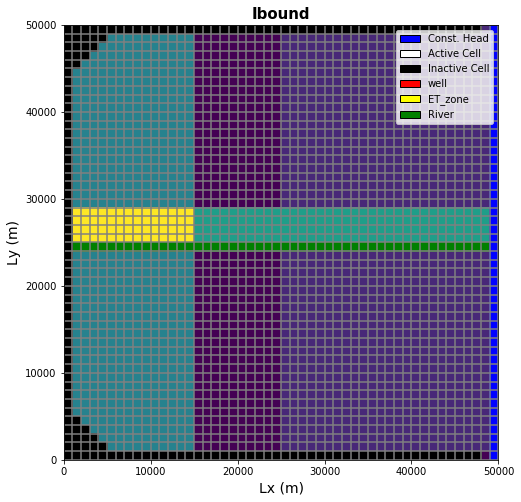

In [11]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

modelmap = flopy.plot.PlotMapView(model=m)
grid = modelmap.plot_grid()
zones = ET_zone + recharge_zone
quadmesh = modelmap.plot_array(zones)
#quadmesh = modelmap.plot_array(rech_zone_forced) #, color='purple')
riv_plot = modelmap.plot_bc(ftype='RIV')
#chd_plot = modelmap.plot_bc(ftype='CHD')
#quadmesh = modelmap.plot_bc('WEL')
#quadmesh = modelmap.plot_array(win_sq_array)
#quadmesh = modelmap.plot_bc('WEL')
quadmesh = modelmap.plot_ibound(ibound[0])



#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                    mp.patches.Patch(color='red',label='well',ec='black'), 
                   mp.patches.Patch(color='yellow',label='ET_zone',ec='black'),
                    #mp.patches.Patch(color='orange',label='Recharge',ec='black'),
                    mp.patches.Patch(color='green',label='River',ec='black')
                   ])

plt.show(modelmap)
#plt.savefig('Domaingrid.png')
#fig = plt.figure(figsize=(8, 8))
#ax = fig.add_subplot(1, 1, 1, aspect='equal')
#mapview = flopy.plot.PlotMapView(model=m1)
#ibound = mapview.plot_ibound()
#wel = mapview.plot_bc("WEL")
#linecollection = mapview.plot_grid()

### Cross section of the layered model
For more examples of cross section plotting check out this notebook: https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3.3_PlotCrossSection.ipynb 

C:\Users\HG\Anaconda3\lib\site-packages\flopy\plot\plotbase.py:368: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plotarray[idx] = 1


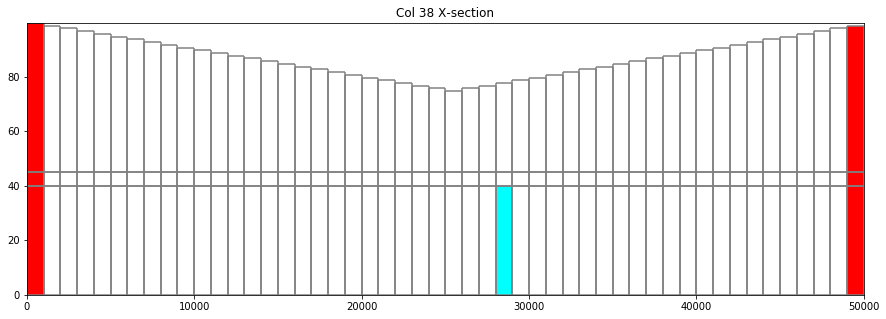

In [12]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'column': 37}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
patches = xsect.plot_bc('WEL', color='cyan')
linecollection = xsect.plot_grid(color='gray')
t = ax.set_title('Col 38 X-section')

# 5. Add particles 


In [13]:
#moddirmp="C:/Users/HG/Documents/AHWR_582/AFinalPro/GroMore_Project/Tesfa/mpath7.exe"
#modelname = "scenario_1"
#mpname=os.path.join(modelname + '_mp')

#Adding Particles
# 1.  
# Define a set of grid cells where particles will be added to (plocs)
# specify the placement within each grid cell using the localx, localy and locaz parameters

#make a list of the cells you want to add where cells are specified by ther (layer, row, column)
#plocs = []
#for idx in range(nrow):
#    plocs.append((0, idx, 0))
##print(plocs)

#part1 = flopy.modpath.ParticleData(plocs, drape=1, structured=True,localx=0.5, localy=0.5, localz=0.99 )
#pg1 = flopy.modpath.ParticleGroup(particlegroupname='PG2', particledata=part1,filename='ex01a.pg2.sloc')


#2. using regions and cell divisons
#Set the rante of cell to add particles to [layerstart, rowstart, colstart,  layerend, rowend,  colend]

#locsb = [[0, 0, 0, 0, nrow - 1, ncol-1]]

#set the number of particles per cell
#sd = flopy.modpath.CellDataType(drape=0, columncelldivisions=1, rowcelldivisions=1, layercelldivisions=1)

#setup theparticles
#p = flopy.modpath.LRCParticleData(subdivisiondata=[sd], lrcregions=[locsb])
#pg1 = flopy.modpath.ParticleGroupLRCTemplate(particlegroupname='PG1',particledata=p,filename='ex01a.pg1.sloc')
#particlegroups = [pg1]

#defaultiface = {'RECHARGE': 6, 'ET': 6}

#setup  the modpath packages
#mp = flopy.modpath.Modpath7(modelname=modelname + '_mp', flowmodel=m, exe_name=moddirmp)
#mpbas = flopy.modpath.Modpath7Bas(mp, porosity=n, defaultiface=defaultiface)
#mpsim = flopy.modpath.Modpath7Sim(mp, simulationtype='combined',
#                                  trackingdirection='forward',
#                                  weaksinkoption='stop_at',
#                                  weaksourceoption='stop_at',
#                                  budgetoutputoption='summary',
#                                  stoptimeoption='extend', 
#                                  particlegroups= particlegroups)


###NOTE: This is how we inserted particles in class the .create funciton creates a default model 
#So  it is faster but gives you less  control over  parameters like  porosity.
#setup the modpath model starting particles just in the cells you listed and doing backward tracking
#mp = flopy.modpath.Modpath7.create_mp7(modelname=mpname, trackdir='backward', flowmodel=m,  
#                                       rowcelldivisions=1, columncelldivisions=1, layercelldivisions=1,
#                                        exe_name=moddirmp, nodes=nodesr)

#setup the modpath model starting particles everywhere and doing forward tracking
#mp = flopy.modpath.Modpath7.create_mp7(modelname=mpname, trackdir='forward', flowmodel=m,  
#                                       rowcelldivisions=1, columncelldivisions=1, layercelldivisions=1,
#                                        exe_name=moddirmp)

#mp.add_package(rch)
# write modpath datasets
#mp.write_input()

# run modpath
#mp.run_model()

#mp.get_package_list()

# 6. Read in the outputs

###  Heads and budget files

In [14]:
#extract binary data from head file
times = [0] #extract times at end of each stress period
head = {} #create dictionary to store head data at end of each stress period
frf = {} #create dictionary to store flows through right cell face at end of each stress period
fff = {} #create dictionary to store flows through front cell face at end of each stress period
storage = {} #create dictionary to store storage at end of each stress period
consthead = {} #create dictionary to store constant head boundary at end of each stress period
leakage = {} #create dictionary to store leakage at end of each stress period

headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds') #get head data as python object
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc') #get flow data as python object

# with open('FP_heads.csv', 'w', newline='') as csvfile:  #creates an empty csv file called FP_heads
#     writer = csv.writer(csvfile, delimiter=',')        
#     for i in range(len(head[0,:,0])):                    #writes each row
#         writer.writerow(head[0,i,:])

#get data from python objects
head = headobj.get_data(totim=1.0) #append heads to head list for ea stress per
frf = budgobj.get_data(text='FLOW RIGHT FACE',totim=1.0) #append right face flow to frf list for ea stress per
fff = budgobj.get_data(text='FLOW FRONT FACE',totim=1.0) #append front face flow to fff list for ea stress per
#storage = budgobj.get_data(text='STORAGE',totim=1.0) #append front face flow to fff list for ea stress per
consthead = budgobj.get_data(text='CONSTANT HEAD',totim=1.0) #append front face flow to fff list for ea stress per
leakage = budgobj.get_data(text='RIVER LEAKAGE',totim=1.0) #append front face flow to fff list for ea stress per

print(leakage)

    #Head - 3 layer model 
#headobj = bf.HeadFile(modelname1+'.hds')    #reads the binary head file
#times = headobj.get_times()                #returns a list of timesteps
#head = headobj.get_data(totim=times[-1])        #returns a numpy array of heads for specified time (last timestep)


    #Water balance - 3 layer
#budgobj = bf.CellBudgetFile(modelname1+'.cbc')   #reads the cell budget file    
#print(budgobj.get_unique_record_names())
#kstpkper_list = budgobj.get_kstpkper()          #returns a list of stress periods & timesteps
#frf = budgobj.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
#fff = budgobj.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
#recharge = budgobj.get_data(text='RECHARGE', totim=1.0) 
#print(len(frf))

[rec.array([(1251,     0.      ), (1252,  3932.093   ),
           (1253,  1955.4596  ), (1254,  1358.0104  ),
           (1255,   950.8585  ), (1256,   647.94867 ),
           (1257,   410.21774 ), (1258,   217.16684 ),
           (1259,    56.941677), (1260,   -77.815125),
           (1261,  -191.8727  ), (1262,  -288.3346  ),
           (1263,  -369.03137 ), (1264,  -434.46152 ),
           (1265,  -482.9142  ), (1266,  -467.8085  ),
           (1267,  -525.2379  ), (1268,  -615.61743 ),
           (1269,  -758.7904  ), (1270, -1480.2762  ),
           (1271,  -439.9336  ), (1272,  -489.12134 ),
           (1273,  -564.91565 ), (1274,  -672.31305 ),
           (1275, -1117.7898  ), (1276,  -621.274   ),
           (1277,  -487.9514  ), (1278,  -390.17813 ),
           (1279,  -311.08606 ), (1280,  -243.42802 ),
           (1281,  -183.32582 ), (1282,  -128.60474 ),
           (1283,   -77.94128 ), (1284,   -30.348995),
           (1285,    14.913375), (1286,    58.441986),
         

### Particle outputs 

In [15]:
     #load in the flow path file
#fpth = os.path.join(mpname + '.mppth')
#p = flopy.utils.PathlineFile(fpth)

    #load in the end point file
#fpth = os.path.join(mpname + '.mpend')
#e = flopy.utils.EndpointFile(fpth, verbose=False)

    #make a subset which is all the particles
#pall = p.get_alldata()  #formerly pwb and ewb
#eall = e.get_alldata()

   #make a subset which is the partlces that end in the well 
#rivernode = []
#for col in ncol:
    #nodewell[] = m.dis.get_node([0,26,0], [0,26,1])
#print(nodewell)
#pwell = p.get_destination_pathline_data(dest_cells=nodewell)
#ewell= e.get_destination_endpoint_data(dest_cells=nodewell)

   #Particle pathlines
#fpth1 = os.path.join(mpname1 + '.mppth')
#p1 = flopy.utils.PathlineFile(fpth1)

    #Particle endpoints
#fpth1 = os.path.join(mpname1 + '.mpend')
#e1 = flopy.utils.EndpointFile(fpth1, verbose=False)

   #make a subset which is all the particles
#pall3 = p3.get_alldata()  
#eall3 = e3.get_alldata()
        
    #make a subset which is particles ending in the well
#nodewell_1 = m1.dis.get_node([(2,well_1_row, well_1_col)])
#nodewell_2 = m1.dis.get_node([(0,well_2_row, well_2_col)])
#print(nodewell_1, nodewell_2)
#pwell1 = p1.get_destination_pathline_data(dest_cells=nodewell1)
#ewell1 = e1.get_destination_endpoint_data(dest_cells=nodewell1)

In [27]:
# Check heads at some

print("Head at MW1 = ", head[0, int(MW1_row), int(MW2_col)])
print("Head at MW2 = ", head[0, int(MW2_row), int(MW2_col)])
print("Head at Well_1 = ", head[2, int(well_1_row), int(well_1_col)])

with open('ss1_hds_bot.csv', 'w', newline='') as csvfile:#creates an empty csv file called 'ss1_hds'
    writer = csv.writer(csvfile, delimiter=',')        
    for i in range(len(head[2,:,0])):                    #writes each row
        writer.writerow(head[2,i,:])  #writing out entire layer 1 heads



Head at MW1 =  89.575165
Head at MW2 =  90.63108
Head at Well_1 =  75.28484


In [17]:
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc')
leakage = budgobj.get_data(text='RIVER LEAKAGE',totim=1)
#print(leakage[0])
flux = np.array(range(nper))

for i in range(nper): ##print("Stream Leakage for Stress period %s"%i)
    perflux = 0
    for k in range(len(leakage[0])):
        #print(leakage['sp%s'%i][0][k][1])
        #perflux = perflux + leakage['sp%s'%i][0][k][1]
        flux[i] = flux[i] + leakage[0][k][1]
    #print(perflux)
print(flux)    

[9291]


# 6. Plots
#### Cross section plots

C:\Users\HG\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


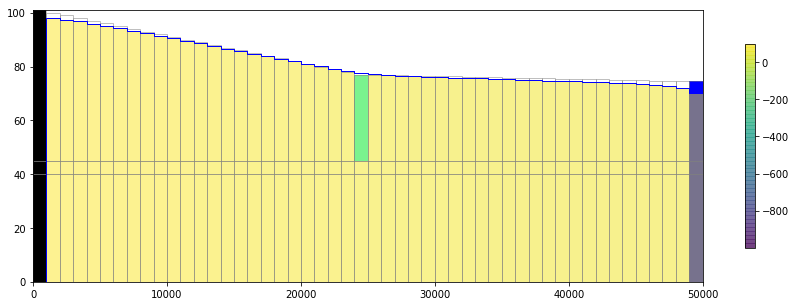

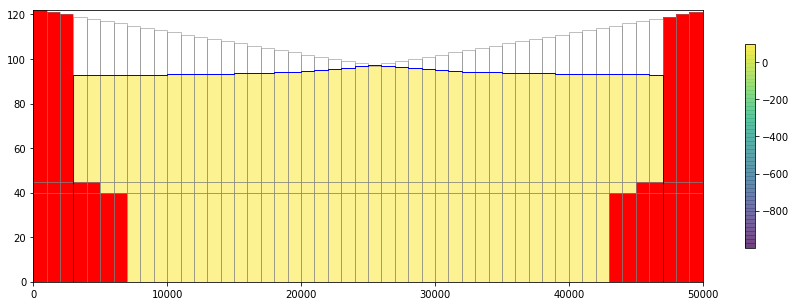

In [18]:

fig1 = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow ='black',color_ch ='blue')
patches = xsect.plot_bc('WEL', color='cyan')

pc = xsect.plot_array(head, masked_values=[999.], head=head, alpha=0.5)
linecollection = xsect.plot_grid(color='gray', lw=0.5)
t = ax.set_title('Row 25 X-section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head[0,:,:]
wt = xsect.plot_surface(head[0,:,:], masked_values=[999.], color='blue', lw=1)



fig2 = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'column': 3}) 
patches = xsect.plot_ibound(color_noflow ='red', color_ch ='blue')
patches = xsect.plot_bc('WEL', color='cyan')
pc = xsect.plot_array(head, masked_values=[999.], head=head, alpha=0.5)

patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
patches = xsect.plot_bc('WEL', color='cyan')
linecollection = xsect.plot_grid(color='gray', lw=0.5)
t = ax.set_title('Column 4 X_section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head[0,:,:], masked_values=[999.], color='blue', lw=1)



# fig2 = plt.figure(figsize=(15, 5))
# ax = fig.add_subplot(1, 1, 1)

# xsect = flopy.plot.PlotCrossSection(model=m, line={'column': 1}) #note use the key 'column' if you want to plot a column instaed
# patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
# #patches = xsect.plot_bc('WEL', color='red')
# # linecollection = xsect.plot_grid(color='green')
# # t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')
# headpc = head[0]
# pc = xsect.plot_array(headpc,head=headpc, alpha=0.5)
# #patches = xsect.plot_ibound(head=head[0][0])
# #patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
# #patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect.plot_grid(color='black', lw=0.5)
# t = ax.set_title('3 Layer Model Row 25 Cross-Section')
# cb = plt.colorbar(pc, shrink=0.75)
# #Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
# wt = xsect.plot_surface(head[0], color='blue', lw=1)

# #print(head[0][0][1][:])

### bottom layer head contours

[  0.          20.856035    26.859673    29.368298    29.762615
  28.367258    25.523901    21.572458    16.831306    11.588758
   6.100617     0.5871373   -4.7719855   -9.8392725  -14.515945
 -18.735394   -22.468515   -25.699942   -28.428377   -30.66359
 -32.570118   -34.069897   -35.19309    -35.98441    -36.5089
 -36.87346    -36.4093     -35.28343    -33.733036   -31.910019
 -29.858845   -27.651392   -25.336191   -22.962605   -20.571049
 -18.198679   -15.879334   -13.643644   -11.519684    -9.532838
  -7.7059054   -6.0588083   -4.6079097   -3.365109    -2.3366218
  -1.5214869   -0.9091733   -0.4759288   -0.17957948   0.        ]
[ -0.        29.415926  50.111397  70.060936  89.34189  108.09106
 126.41492  144.38622  162.05537  179.46028  196.63165  213.59584
 230.37894  247.0114   263.51343  261.72607  259.4801   256.82874
 253.81833  254.55518  249.50444  244.591    239.78052  235.04927
 230.38771  225.80614  221.35596  217.09467  213.07535  209.34367
 205.93779  202.88803  200.21

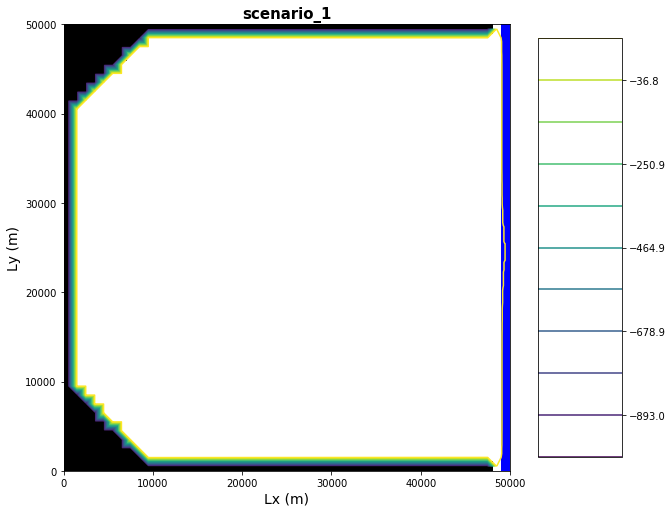

In [29]:



#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))
print(fff[0][0][40])
print(frf[0][2][40])

modelmap = flopy.plot.PlotMapView(model=m, layer=2) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head[0][0].min(),head[0][0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours
#flows = modelmap.plot_discharge(frf1[0][0], fff1[0][0], head=head1[0]) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('scenario_1', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')   

### Plot particle pathlines

In [20]:
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(1, 1, 1)

# ax.set_aspect('equal')
# ax.set_title('1 Layer Scenario Flowlines')
# mm = flopy.plot.PlotMapView(model=m1, ax=ax)
# mm.plot_grid(lw=0.5)
# #mm.plot_pathline(pall1, layer='all', color='blue', lw=0.5, linestyle=':', label='not captured by wells') #,marker='o', markercolor='black', markersize=3, markerevery=5)
# mm.plot_pathline(pwell3, layer='all', color='red', lw=0.5, linestyle=':', label='3 layer') # ,marker='o', markercolor='black', markersize=3, markerevery=5)
# mm.plot_pathline(pwell1, layer='all', color='orange', lw=0.5, linestyle=':', label='1 layer') # ,marker='o', markercolor='black', markersize=3, markerevery=5)
# mm.ax.legend();
# #plt.tight_layout();
# #plt.savefig('Pathlines.png')


### head transect plot

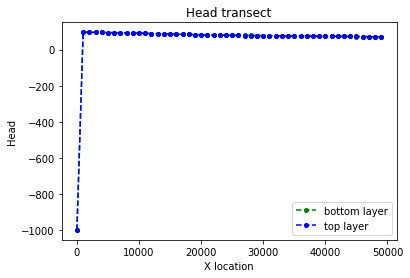

In [21]:
fig4 = plt.figure() 
ax = fig4.add_subplot(1, 1, 1)

x=np.arange(0,50000,1000) 
plt.plot(x,head[2,int(well_1_row),:],marker='o', color='green', markersize=4, linestyle='--', label="bottom layer")
plt.plot(x,head[0,int(well_1_row),:],marker='o', color='blue', markersize=4, linestyle='--', label="top layer")
plt.title('Head transect')
plt.xlabel('X location')
plt.ylabel('Head')
plt.legend()
plt.savefig('Head_Transect.png')
